In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import BoundaryNorm
import pandas as pd
from glob import glob
from scipy.interpolate import griddata

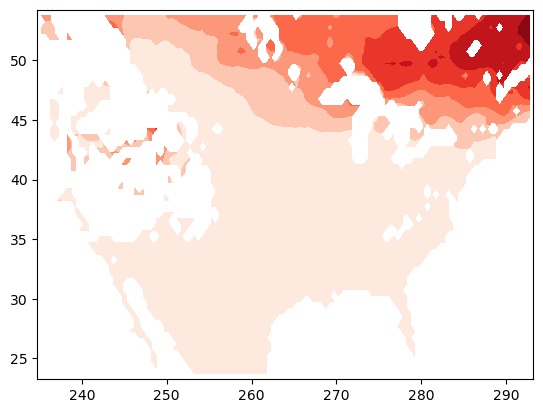

In [3]:
# Read the GlobSnow grid
def last_day(array4D):
    def check(vec):
        has_snow = np.where(vec[:183] > 0)[0]
        if len(has_snow) > 0:
            return has_snow[-1]
        else:
            return np.nan
    return np.apply_along_axis(check, axis = 1, arr = array4D)

latlon = xr.open_dataset(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 
    'GlobSnow', 'ESA-GlobSnow-L3B-SWE_avg-daily-19790911-fv2.0.nc'))
lats = latlon['lat'].copy(deep = True)
lons = latlon['lon'].copy(deep = True)
lons = lons.where(lons > 0, lons + 360)
mask = (lats >= 23.25) & (lats <= 54.25) & (lons >= 234.75) & (lons <= 293.25)
latlon.close()

# Read the GlobSnow data
filelist = sorted(glob(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'GlobSnow',
                                    '*northern_hemisphere_swe_0.25grid.nc')))
filelist = [f for f in filelist if (int(f.split('/')[-1][:4]) >= 1990) & \
            (int(f.split('/')[-1][:4]) <= 2010) & (int(f.split('/')[-1][4:6]) <= 6)]
time = [pd.Timestamp(year = int(f.split('/')[-1][:4]), month = int(f.split('/')[-1][4:6]), 
                     day = int(f.split('/')[-1][6:8])) for f in filelist]
globsnow = xr.open_mfdataset(filelist, concat_dim = 'time', combine = 'nested')
globsnow['time'] = time
swe_globsnow = globsnow['swe'].transpose('time', 'y', 'x').where(mask)

# Set the < 0 values to NaN
swe_globsnow = swe_globsnow.where(swe_globsnow >= 0)

# Subset to CONUS
within_x = np.any(mask, axis = 0)
within_y = np.any(mask, axis = 1)
swe_globsnow = swe_globsnow[:, within_y, within_x].copy()
lats = lats[within_y, within_x]
lons = lons[within_y, within_x]

globsnow.close()

# Test performing 2D interpolation on one time slice
new_lat = np.arange(23.25, 54.26, 0.5)
new_lon = np.arange(234.75, 293.26, 0.5)
new_lat_grid, new_lon_grid = np.meshgrid(new_lat, new_lon)
original_lat = lats.values.reshape(-1)
original_lon = lons.values.reshape(-1)
original_z = swe_globsnow[:, :, :].mean(axis = 0).values.reshape(-1)
new_z = griddata((original_lat, original_lon), original_z, (new_lat_grid, new_lon_grid), 
                 method='linear')

plt.figure()
plt.contourf(new_lon, new_lat, new_z.T, cmap = 'Reds')

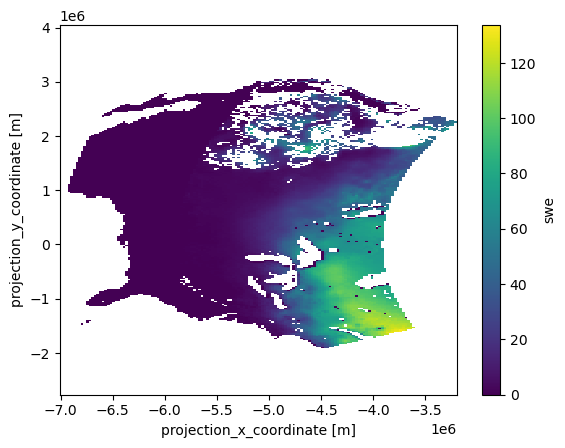

In [4]:
swe_globsnow.mean(axis = 0).plot()

In [5]:
# Identify the last day of snow
def last_day(array3D):
    def check(vec):
        # for GlobSnow, vec is guaranteed to end in June
        has_snow = np.where(vec > 0)[0]
        if len(has_snow) > 0:
            return has_snow[-1]
        else:
            return np.nan
    def check_wrapped(array3D, axis = 0):
        return np.apply_along_axis(check, axis = axis, arr = array3D)
    return array3D.reduce(check_wrapped, dim = 'time')

last_globsnow = swe_globsnow.groupby('time.year').apply(last_day)

# Actually perform 2D interpolation
original_z = last_globsnow.values.reshape(last_globsnow.shape[0], -1)
new_z = np.full([last_globsnow.shape[0], len(new_lat), len(new_lon)], np.nan)
for i in range(last_globsnow.shape[0]):
    new_z[i, :, :] = griddata((original_lat, original_lon), original_z[i, :], 
                              (new_lat_grid, new_lon_grid), method='linear').T

/tmp/ipykernel_470431/107964374.py:3: RuntimeWarning: Mean of empty slice
  cf = ax.contourf(new_lon, new_lat, np.nanmean(new_z, axis = 0), cmap = 'viridis',


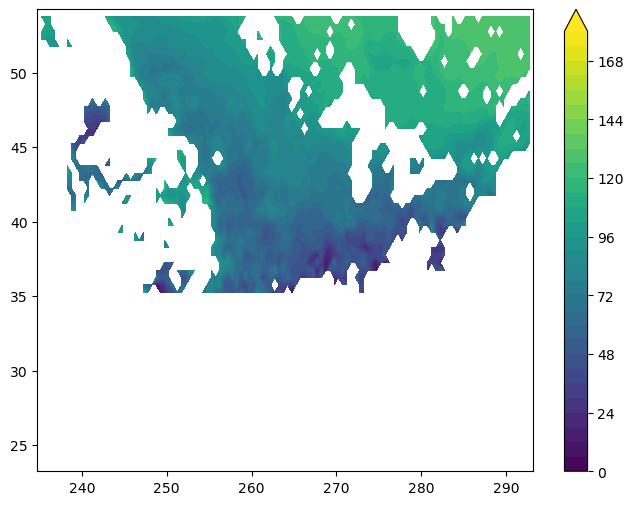

In [6]:
# Plot the average last day of snow
fig, ax = plt.subplots(figsize = (8, 6))
cf = ax.contourf(new_lon, new_lat, np.nanmean(new_z, axis = 0), cmap = 'viridis', 
                 levels = np.linspace(0, 180, 31), vmin = 0, vmax = 180, extend = 'max')
plt.colorbar(cf, ax = ax)